In [283]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Append the parent directory to the Python path^
sys.path.append(os.path.abspath(".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer

from scripts.gradient_descent import CustomLinearRegression

from scripts.evaluation import evaluate_model, compare_models, cMSE_error
from scripts.models import (
    evaluate_knn_imputation, 
    evaluate_iterative_imputation, 
    create_polynomial_model, 
    cross_val_polynomial, 
    cross_val_knn, 
    create_KNN_model, 
    run_imputation_baseline_model,
    create_baseline_model
)
from scripts.plots import (
    plot_mse_per_degree,
    plot_best_degrees,
    plot_feature_complexity,
    plot_mse_metric_weight,
    plot_y_yhat
)
from scripts.utils import (
    save_model,
    load_model,
    load_kaggle_df,
    load_starting_df,
    load_train_test,
    create_submission_csv,
    missing_columns
)


# Load data
startingDF = load_starting_df()
kaggleDF = load_kaggle_df()
kf = KFold(n_splits=10, shuffle=True)
task3_results = []


## Task 3 - Handling missing Data
We now add to the data used in Task 2 the data points where the features have missing data. We still cannot take advantage of the unlabeled data, as our ML task is regression, a supervised learning task.

In [285]:
X_train, X_test, y_train, y_test = load_train_test()

X_train_reduced = X_train.drop(columns=missing_columns)
X_test_reduced = X_test.drop(columns=missing_columns)

X_train_reduced = X_train_reduced[y_train["SurvivalTime"].notna()]
y_train_reduced = y_train[y_train["SurvivalTime"].notna()]

X_test_reduced = X_test_reduced[y_test["SurvivalTime"].notna()]
y_test_reduced = y_test[y_test["SurvivalTime"].notna()]

# Filter out rows where Censored is 1
X_test_no_censored = X_test_reduced[y_test_reduced["Censored"] == 0]
y_test_no_censored = y_test_reduced[y_test_reduced["Censored"] == 0]

In [286]:
X_train = X_train[y_train["SurvivalTime"].notna()]
y_train = y_train[y_train["SurvivalTime"].notna()]

X_test = X_test[y_test["SurvivalTime"].notna()]
y_test = y_test[y_test["SurvivalTime"].notna()]

In [287]:
y_pred_baseline = load_model("baseline_reduced_features").predict(X_test_no_censored)
y_pred_poly = load_model("poly_reduced_features").predict(X_test_reduced)
y_pred_GD = load_model("Gradient_Descent_model").predict(X_test_reduced)
y_pred_knn = load_model("knn_reduced_features").predict(X_test_reduced)

df = compare_models([("Polynomal Regression", y_test_reduced["SurvivalTime"], y_pred_poly, y_test_reduced["Censored"]), ("Gradient Descent", y_test_reduced["SurvivalTime"], y_pred_GD, y_test_reduced["Censored"]),  ("Baseline Model", y_test_no_censored["SurvivalTime"], y_pred_baseline,  y_test_no_censored["Censored"]), ("KNN (k = 20)", y_test_reduced["SurvivalTime"], y_pred_knn, y_test_reduced["Censored"])])
df.T.sort_values("cMSE")

/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipelin

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
KNN (k = 20),5.013636,0.172727,1.363455,1.806297,3.016536
Polynomal Regression,4.536992,0.003830,1.387678,1.812420,3.020622
Gradient Descent,4.419305,0.031219,1.590229,1.919965,3.438490
Baseline Model,4.961072,0.171241,1.544248,2.107924,4.445811


### Task 3.1 Missing data imputation

- Experiment with completing missing data using imputation techniques in [Scikit-Learn](https://scikit-learn.org/stable/modules/impute.html) and [here](https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html), using the baseline model.
- Compare the results with Task 1.2  in the slides, using a table with the error statistics and the y-y hat plot. Present evidence of your analysis.
- Choose the best imputation strategies obtained with the baseline and apply them to the best models of Task 2. Analyze your results and report them in the slides, with evidence from your experiments.

#### Simple Imputer
[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#simpleimputer)    
Provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located.   
Univariate feature Imputation:   
- If "mean", then replace missing values using the mean along each column. Can only be used with numeric data.
- If "median", then replace missing values using the median along each column. Can only be used with numeric data.
- If "most_frequent", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.
- If "constant", then replace missing values with fill_value. Can be used with strings or numeric data.
- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column.

In [288]:
results, best_strat = run_imputation_baseline_model(X_train, y_train)
df_simple = pd.DataFrame(results, columns=["Model", "MSE"])
df_simple.sort_values(by="MSE", ascending=True)

Evaluating imputation strategy: mean
Average MSE for mean imputation: 3.0389
Evaluating imputation strategy: median
Average MSE for median imputation: 3.2636
Evaluating imputation strategy: most_frequent
Average MSE for most_frequent imputation: 3.1347


,Model,MSE
0,mean model,3.038923
2,most_frequent model,3.134671
1,median model,3.263605


mean Imputation MSE: 2.325514529462794


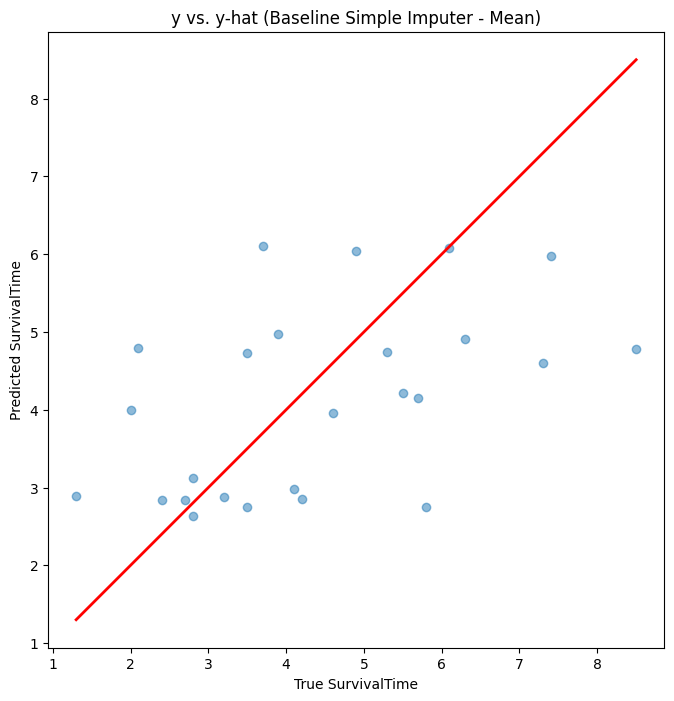

In [289]:
imp = SimpleImputer(strategy=best_strat)

X_train_imp = pd.DataFrame(imp.fit_transform(X_train))
X_test_imp = pd.DataFrame(imp.fit_transform(X_test))
mean_imp_model = create_baseline_model(X_train_imp, y_train["SurvivalTime"])
y_pred_mean = mean_imp_model.predict(X_test_imp)
print(f"{best_strat} Imputation MSE: {cMSE_error(y_test["SurvivalTime"], y_pred_mean, y_test["Censored"])}")
task3_results.append(("Mean Imputation", y_test["SurvivalTime"], y_pred_mean, y_test["Censored"]))

plot_y_yhat(y_test["SurvivalTime"], y_pred_mean, "y vs. y-hat (Baseline Simple Imputer - Mean)")

save_model(mean_imp_model, "simple_imp_model_best")

#### KNN Imputer
[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#knnimputer)   
The KNNImputer class provides imputation for filling in missing values using the k-Nearest Neighbors approach.   
Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature.

In [290]:
k_values = list(range(1, 51))
evaluations, bestK = evaluate_knn_imputation(X_train, y_train, k_values)
df_knn = pd.DataFrame(evaluations, columns=["Model", "MSE"])
df_knn.sort_values(by="MSE", ascending=True)

,Model,MSE
12,KNN (k=13),2.999985
27,KNN (k=28),3.000913
10,KNN (k=11),3.006355
9,KNN (k=10),3.031010
24,KNN (k=25),3.038406
30,KNN (k=31),3.039885
46,KNN (k=47),3.044183
32,KNN (k=33),3.044411
11,KNN (k=12),3.058989
37,KNN (k=38),3.070190


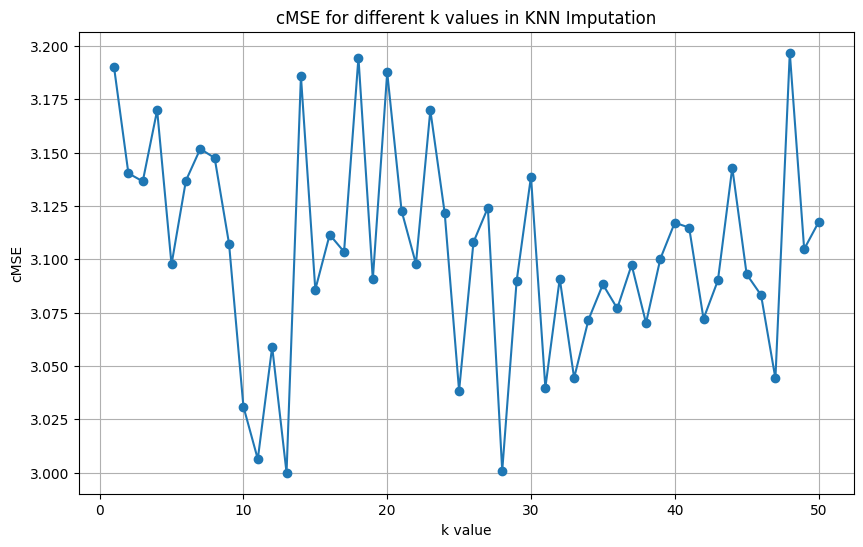

In [291]:
mean_errors = df_knn['MSE']
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_errors, marker='o')
plt.xlabel('k value')
plt.ylabel('cMSE')
plt.title('cMSE for different k values in KNN Imputation')
plt.grid(True)
plt.show()

In [292]:
from sklearn.impute import KNNImputer

imp = KNNImputer(n_neighbors=bestK)

X_train_imp = pd.DataFrame(imp.fit_transform(X_train))
X_test_imp = pd.DataFrame(imp.fit_transform(X_test))
kNN_imp_model = create_baseline_model(X_train_imp, y_train["SurvivalTime"])
y_pred = kNN_imp_model.predict(X_test_imp)
results = evaluate_model(y_test["SurvivalTime"], y_pred, y_test["Censored"])
print(f"cMSE: {cMSE_error(y_test['SurvivalTime'], y_pred, y_test['Censored'])}")
task3_results.append(("KNN Imput Model", y_test["SurvivalTime"], y_pred, y_test["Censored"]))

save_model(kNN_imp_model, "knn_imp_model_best")
results

cMSE: 2.3243430932383244


{'Max Error': 3.730550722544093,
 'Min Error': 0.026737972541241994,
 'Mean Error': 1.3157875824455496,
 'Std Dev of Error': 1.609137739944041,
 'cMSE': 2.3243430932383244}

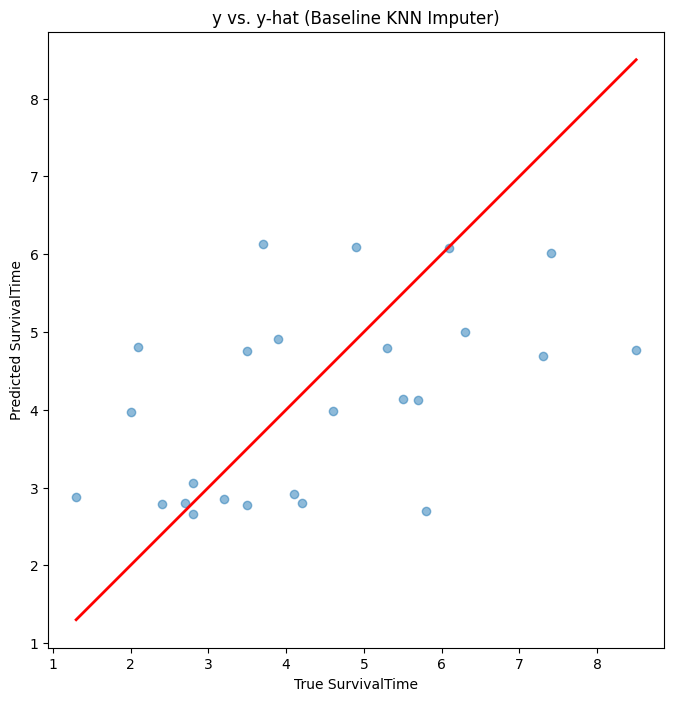

In [293]:
plot_y_yhat(y_test["SurvivalTime"], y_pred, "y vs. y-hat (Baseline KNN Imputer)")

#### Iteractive Imputer (Experimental)

In [294]:
max_iterations = list(range(1, 51))
evaluations, bestIter = evaluate_iterative_imputation(X_train, y_train, max_iterations)
df_II = pd.DataFrame(evaluations, columns=["Model", "MSE"])
df_II.sort_values(by="MSE", ascending=True)

Evaluating Iterative Imputer with max_iter=1
Average MSE for max_iter=1: 3.1194
Evaluating Iterative Imputer with max_iter=2


/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/fcd/Work/

Average MSE for max_iter=2: 3.0563
Evaluating Iterative Imputer with max_iter=3
Average MSE for max_iter=3: 3.1273
Evaluating Iterative Imputer with max_iter=4
Average MSE for max_iter=4: 3.0878
Evaluating Iterative Imputer with max_iter=5
Average MSE for max_iter=5: 3.0967
Evaluating Iterative Imputer with max_iter=6
Average MSE for max_iter=6: 3.0795
Evaluating Iterative Imputer with max_iter=7
Average MSE for max_iter=7: 3.0158
Evaluating Iterative Imputer with max_iter=8
Average MSE for max_iter=8: 3.0516
Evaluating Iterative Imputer with max_iter=9
Average MSE for max_iter=9: 3.0798
Evaluating Iterative Imputer with max_iter=10
Average MSE for max_iter=10: 3.1918
Evaluating Iterative Imputer with max_iter=11
Average MSE for max_iter=11: 3.1539
Evaluating Iterative Imputer with max_iter=12
Average MSE for max_iter=12: 3.0775
Evaluating Iterative Imputer with max_iter=13
Average MSE for max_iter=13: 3.1245
Evaluating Iterative Imputer with max_iter=14
Average MSE for max_iter=14: 3.

,Model,MSE
18,Iterative Imputer (max_iter=19),3.014399
6,Iterative Imputer (max_iter=7),3.015839
24,Iterative Imputer (max_iter=25),3.027569
43,Iterative Imputer (max_iter=44),3.041887
17,Iterative Imputer (max_iter=18),3.045489
25,Iterative Imputer (max_iter=26),3.051475
7,Iterative Imputer (max_iter=8),3.051630
14,Iterative Imputer (max_iter=15),3.055075
1,Iterative Imputer (max_iter=2),3.056277
49,Iterative Imputer (max_iter=50),3.058698


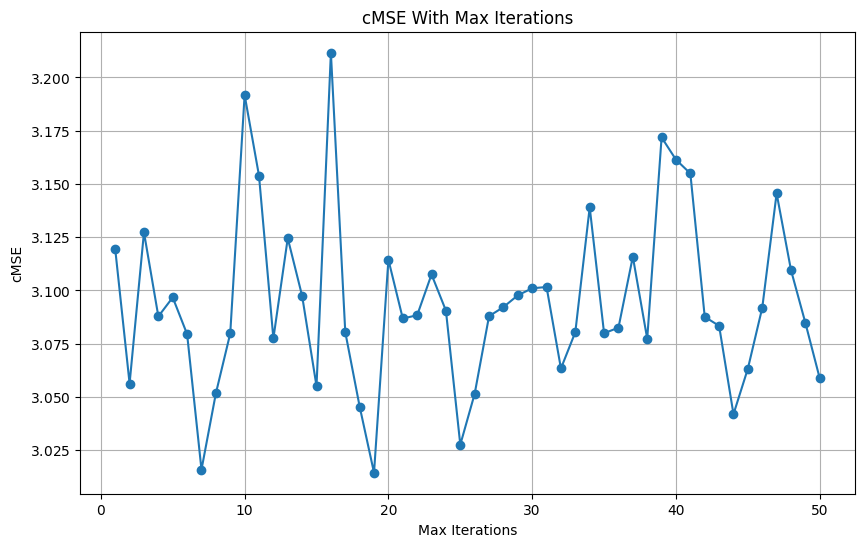

In [295]:
mean_errors = df_II['MSE']
plt.figure(figsize=(10, 6))
plt.plot(max_iterations, mean_errors, marker='o')
plt.xlabel('Max Iterations')
plt.ylabel('cMSE')
plt.title('cMSE With Max Iterations')
plt.grid(True)

# Disable scientific notation on y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().yaxis.get_major_formatter().set_useOffset(False)

plt.show()

In [296]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=bestIter)

X_train_imp = pd.DataFrame(imp.fit_transform(X_train))
X_test_imp = pd.DataFrame(imp.fit_transform(X_test))
iterative_imp_model = create_baseline_model(X_train_imp, y_train["SurvivalTime"])
y_pred = iterative_imp_model.predict(X_test_imp)
print(f"cMSE: {cMSE_error(y_test['SurvivalTime'], y_pred, y_test['Censored'])}")
task3_results.append(("Iterative", y_test["SurvivalTime"], y_pred, y_test["Censored"]))

save_model(iterative_imp_model, "iterative_imp_model_best")

cMSE: 2.5249015259394234


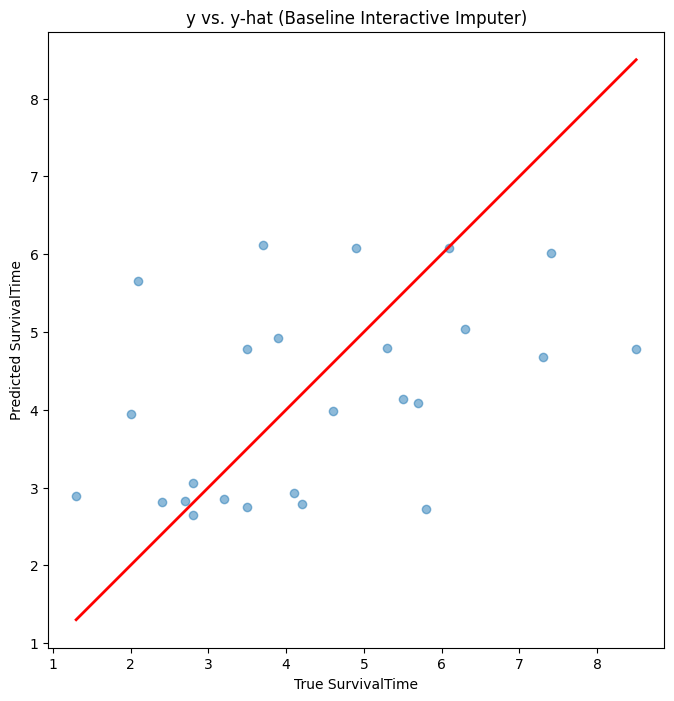

In [297]:
plot_y_yhat(y_test["SurvivalTime"], y_pred, "y vs. y-hat (Baseline Interactive Imputer)")

#### Overview

In [298]:
merged_df = pd.concat([df_II.T, df_knn.T, df_simple.T], axis=1)
merged_df.T.sort_values("MSE")

,Model,MSE
12,KNN (k=13),2.999985
27,KNN (k=28),3.000913
10,KNN (k=11),3.006355
18,Iterative Imputer (max_iter=19),3.014399
6,Iterative Imputer (max_iter=7),3.015839
...,...,...
9,Iterative Imputer (max_iter=10),3.191795
17,KNN (k=18),3.19457
47,KNN (k=48),3.196865
15,Iterative Imputer (max_iter=16),3.211624


In [299]:
compare_models(task3_results).T.sort_values(by="cMSE", ascending=True)
task3_results

[('Mean Imputation',
  0     6.1
  1     5.5
  2     5.7
  3     3.2
  4     2.8
  5     7.3
  6     1.3
  7     3.5
  8     2.0
  9     4.2
  10    2.8
  11    4.6
  12    4.9
  13    2.1
  14    5.8
  15    8.5
  16    4.1
  17    3.5
  18    3.9
  19    6.3
  20    2.7
  21    5.3
  22    7.4
  23    2.4
  24    3.7
  Name: SurvivalTime, dtype: float64,
  array([6.08014727, 4.2142215 , 4.1496986 , 2.88312161, 3.12173343,
         4.59880274, 2.88571572, 2.74658318, 3.99084347, 2.85446819,
         2.63705488, 3.95317329, 6.04655724, 4.79620129, 2.7443566 ,
         4.77775608, 2.98446153, 4.73561758, 4.9795545 , 4.91550236,
         2.83687127, 4.74009606, 5.97573416, 2.83388176, 6.09984937]),
  0     0
  1     0
  2     0
  3     0
  4     0
  5     0
  6     0
  7     0
  8     0
  9     0
  10    0
  11    0
  12    0
  13    0
  14    0
  15    0
  16    0
  17    1
  18    1
  19    1
  20    1
  21    1
  22    1
  23    1
  24    1
  Name: Censored, dtype: int64),
 ('KNN Impu

### Task 3.2 Train Models that do not require imputation
- Develop code to apply models and techniques that can directly handle missing data, such as tree-based methods, like decision trees.
- Experiment with the Scikit-Learn model [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html), and CatBoost’s [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor). For installation instructions of the CatBoost Library check [here](https://catboost.ai/en/docs/concepts/python-installation). You can use conda or pip.
- There is a tutorial on using CatBoost for censored data [here](https://github.com/catboost/tutorials/blob/master/regression/survival.ipynb). Try the Accelerated Failure Time (AFT) CatBoost applied to the assignment data.

##### Custom Decision tree using cMSE

In [300]:
# from scripts.decision_tree import DecisionTreeRegressor
# from scripts.models import cross_val_DecisionTree


# dt = DecisionTreeRegressor()
# cMSEs, y_preds = cross_val_DecisionTree(X_train, y_train, dt)
# np.average(cMSEs)

#### Decision Tree

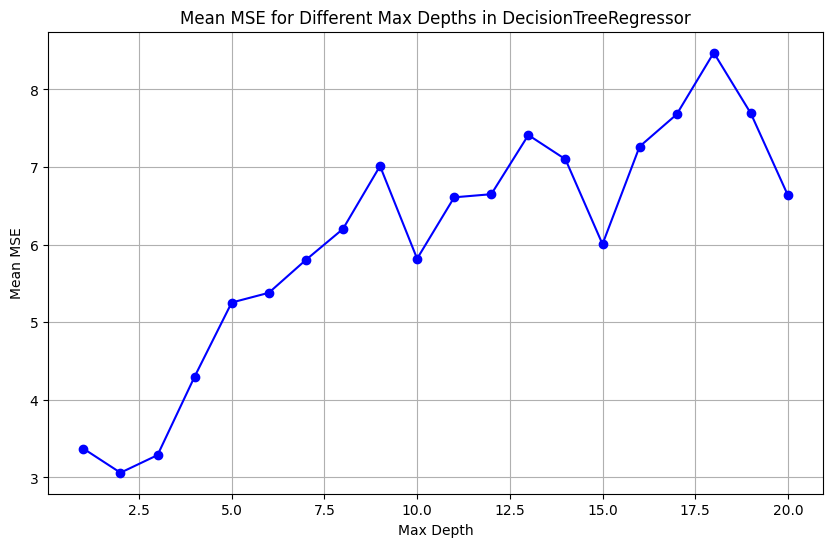

Best max depth: 2
Test MSE: 2.890286291377485
Test cMSE: 2.5722116016320355


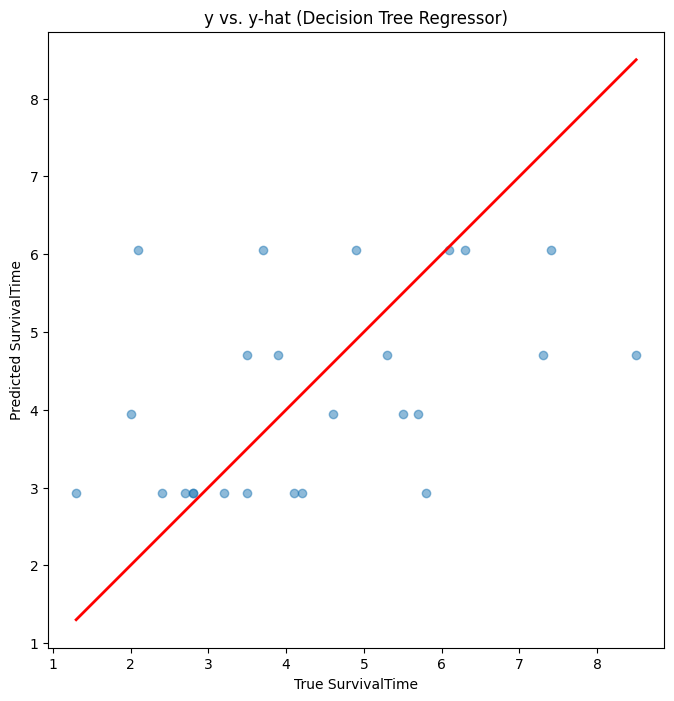

In [301]:
from scripts.models import evaluate_decision_tree
y_train["SurvivalTime"]

best_max_depth, dt_regressor, rmse_dt, cMSE_err = evaluate_decision_tree(X_train, y_train, X_test, y_test)

In [302]:
save_model(dt_regressor, "best_dt_model")
y_pred = dt_regressor.predict(X_test)
task3_results.append(("DecisionTree", y_test["SurvivalTime"], y_pred, y_test["Censored"]))

#### Random Forests

In [303]:
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10, 30]
}

rf = RandomForestRegressor()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search_rf.fit(X_train, y_train["SurvivalTime"])

best_params_rf = grid_search_rf.best_params_
best_score_rf = -grid_search_rf.best_score_

print(f"Best parameters: {best_params_rf}")
print(f"Best MSE: {best_score_rf}")

# Fit the model with the best parameters on the entire training data
best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train["SurvivalTime"])

y_pred_rf = best_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test["SurvivalTime"], y_pred_rf))

print(f"Test MSE: {rmse_rf}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best MSE: 3.083944416693379
Test MSE: 1.7141461429407918


Best Parameters: n_estimators=10, max_depth=30, min_samples_leaf=10
Validation MSE: 3.1486191528733714
Test MSE: 2.8603405802668864


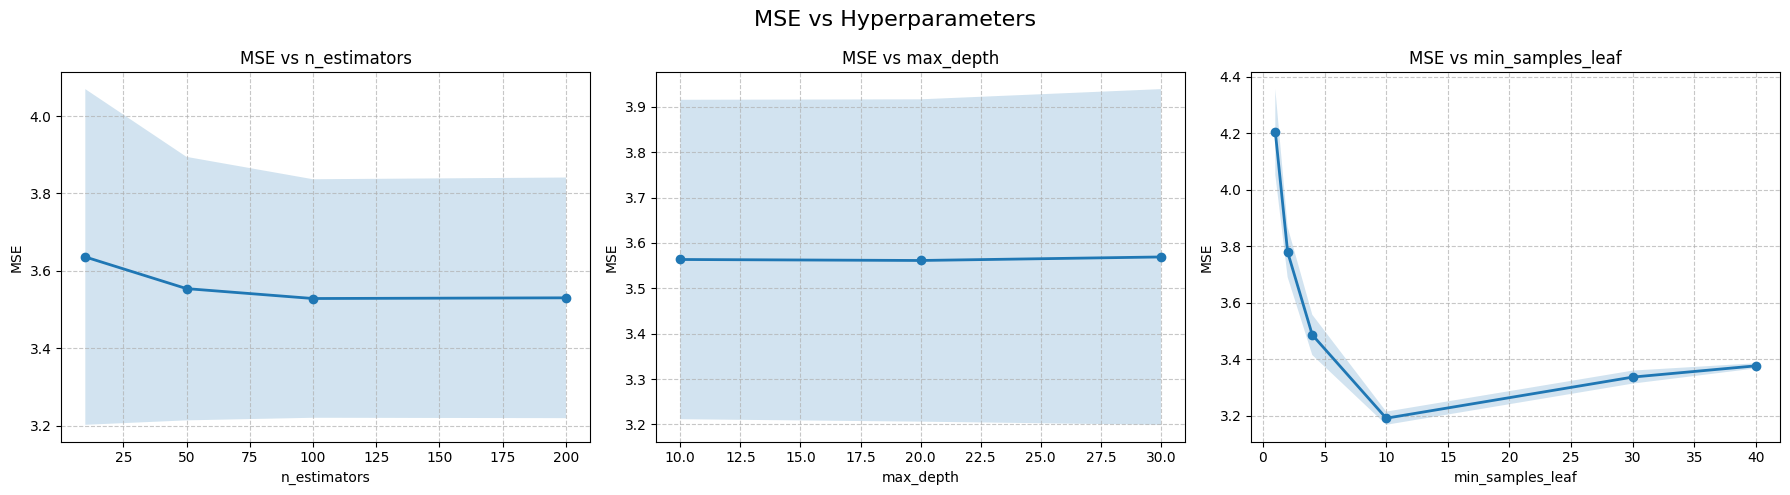

In [304]:
from scripts.models import evaluate_and_plot_rf


n_estimators = [10, 50, 100, 200]
max_depths = [None, 10, 20, 30]
min_samples_split = [2, 5, 10, 20, 30]
min_samples_leafs = [1, 2, 4, 10, 30, 40]

# Call the function
best_params, best_model, rmse_test, results_df = evaluate_and_plot_rf(
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    n_estimators=n_estimators, 
    max_depths=max_depths, 
    min_samples_leafs=min_samples_leafs
)

In [305]:
random_forest_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=10
)

random_forest_best.fit(X_train, y_train["SurvivalTime"])
y_pred = random_forest_best.predict(X_test)
task3_results.append(("Random Forest", y_test["SurvivalTime"], y_pred, y_test["Censored"]))

save_model(random_forest_best, "random_forest_best")

#### HistGradientBoostingRegressor
Experiment with the Scikit-Learn model [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html).

In [306]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None,2, 3, 5, 7, 10],
    'min_samples_leaf': [20, 50, 100]
}

hist_gbr = HistGradientBoostingRegressor()

grid_search = GridSearchCV(estimator=hist_gbr, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train["SurvivalTime"])

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best MSE: {best_score}")

# Fit the model with the best parameters on the entire training data
best_hist_gbr = grid_search.best_estimator_
best_hist_gbr.fit(X_train, y_train["SurvivalTime"])

y_pred_hist_gbr = best_hist_gbr.predict(X_test)

rmse_hist_gbr = np.sqrt(mean_squared_error(y_test["SurvivalTime"], y_pred_hist_gbr))

print(f"Test MSE: {rmse_hist_gbr}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 2, 'max_iter': 200, 'min_samples_leaf': 20}
Best MSE: 3.1572319478449526
Test MSE: 1.6446735452736974



Best Parameters: Learning Rate=0.01, Max Iter=200, Max Depth=2, Min Samples Leaf=10
Best Mean MSE: 3.028295579443335
Test MSE: 2.7294172039359976
Test cMSE: 2.42774371579444


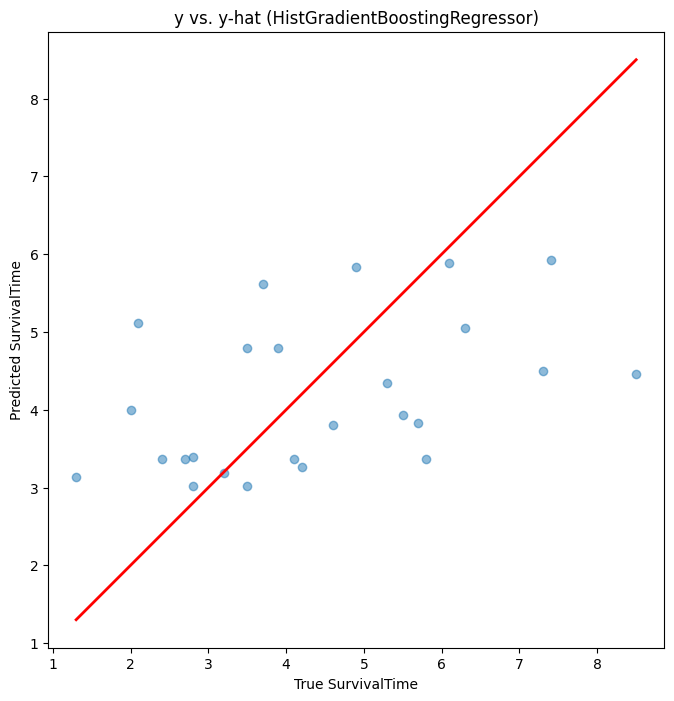

In [307]:
from scripts.models import evaluate_HistGradientBoostingRegressor
from scripts.plots import visualize_parameter_search

learning_rates=[0.01, 0.1, 0.2]
max_iters=[5, 10, 50, 100, 200, 300]
max_depths=[None, 2, 3, 5, 7, 10]
min_samples_leafs=[5, 10 ,20, 50, 100]

best_params, best_model, rmse_hgb, cMSE_err, results = evaluate_HistGradientBoostingRegressor(X_train,
                                                                                              y_train,
                                                                                              X_test,
                                                                                              y_test,
                                                                                              learning_rates,
                                                                                              max_iters,
                                                                                              max_depths,
                                                                                              min_samples_leafs
                                                                                              )

In [308]:
y_pred = best_model.predict(X_test)
print(f"cMSE Error: {cMSE_error(y_test['SurvivalTime'], y_pred, y_test['Censored'])}")
task3_results.append(("HistGradientBoosting", y_test["SurvivalTime"], y_pred, y_test["Censored"]))
save_model(best_model, "best_hist_boost_rgr")

cMSE Error: 2.42774371579444


In [309]:
y_pred_missing = load_model("best_hist_boost_rgr").predict(kaggleDF)

In [310]:
create_submission_csv(best_model.predict(kaggleDF), "handle-missing-submission-07.csv")

CSV file 'handle-missing-submission-07.csv' has been created.


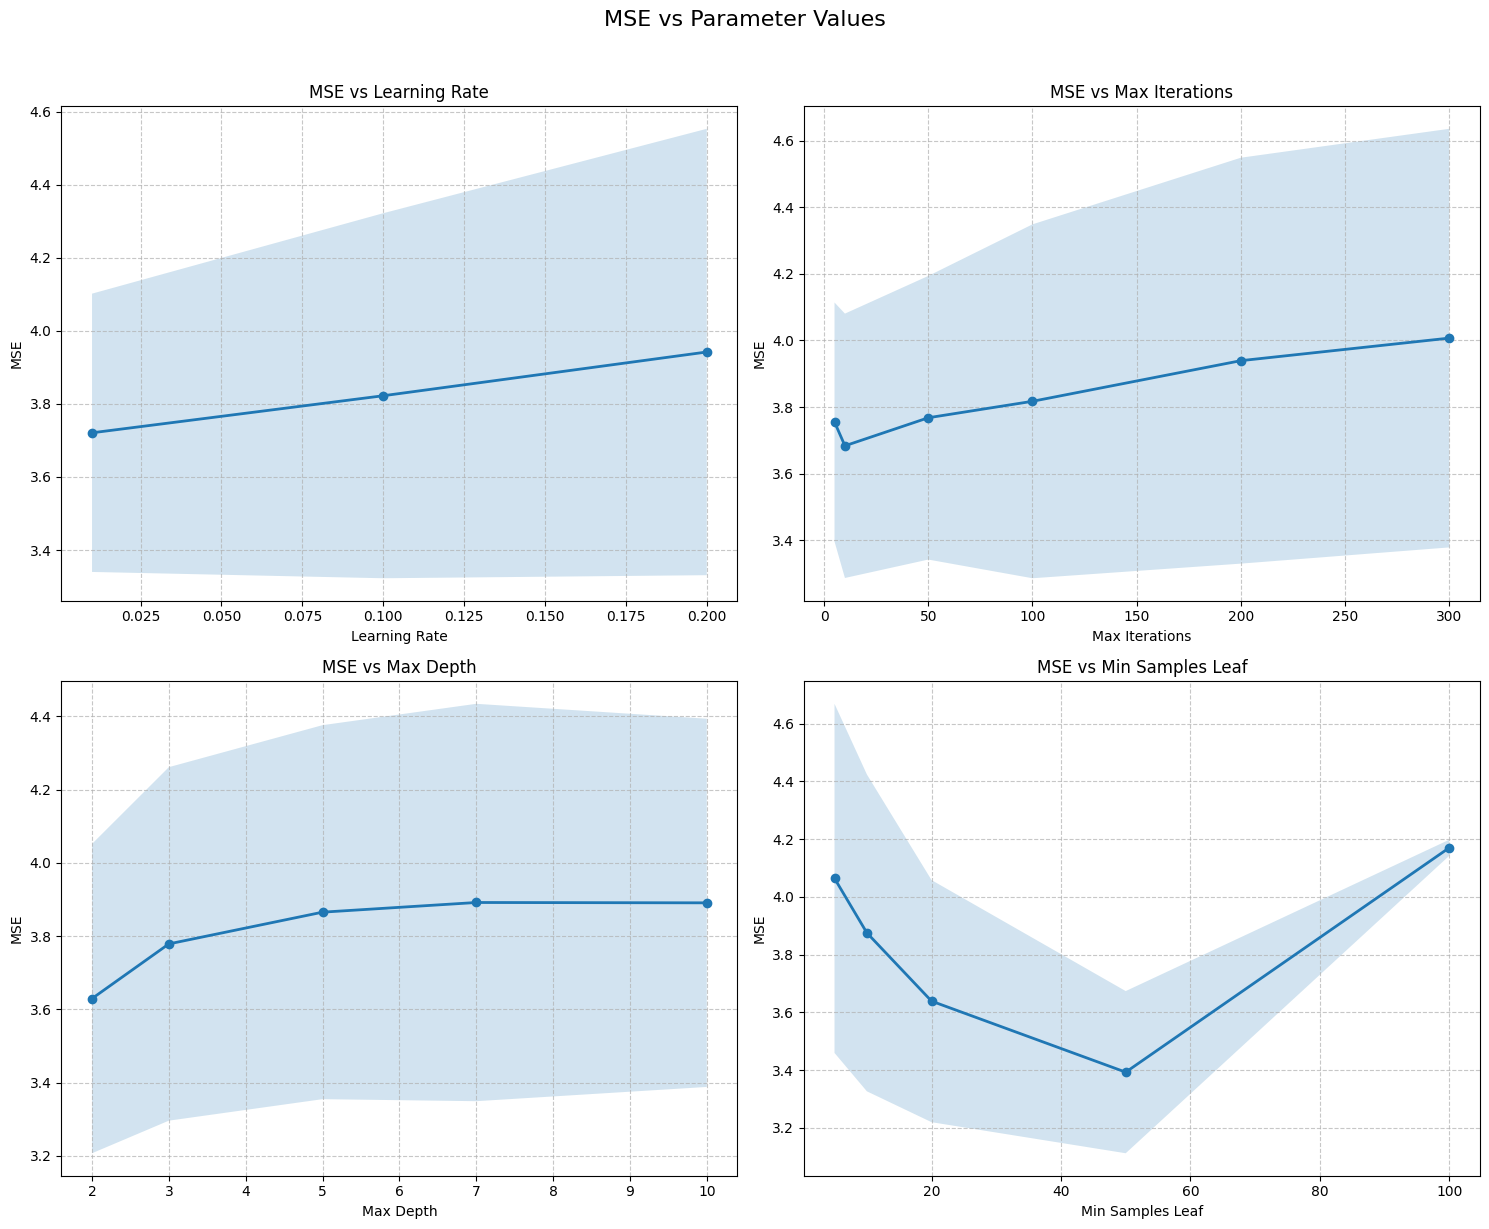

In [311]:
_ = visualize_parameter_search(results)

#### CatBoostRegressor
- There is a tutorial on using CatBoost for censored data [here](https://github.com/catboost/tutorials/blob/master/regression/survival.ipynb). Try the Accelerated Failure Time (AFT) CatBoost applied to the assignment data.
This is wrong

In [312]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostRegressor
from scripts.utils import X_cols_universal


features = X_train.columns.difference(['SurvivalTime', 'Censored'], sort=False)
cat_features = ["Gender", "Stage", "TreatmentType", "TreatmentResponse"]
features

Index(['Age', 'Gender', 'Stage', 'GeneticRisk', 'TreatmentType',
       'ComorbidityIndex', 'TreatmentResponse'],
      dtype='object')

In [313]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostRegressor
from scripts.utils import X_cols_universal
y_train_cat = y_train
y_test_cat = y_test
X_train_cat = X_train
X_test_cat = X_test

# Since we already have the dataset splitted, I'm doing the interval target both on y_train and y_test
# Right Censored: [A, +inf]

y_train_cat['y_lower'] = y_train_cat['SurvivalTime']
y_train_cat['y_upper'] = np.where(y_train['Censored'] == 1, y_train["SurvivalTime"], -1)

y_test_cat['y_lower'] = y_test_cat['SurvivalTime']
y_test_cat['y_upper'] = np.where(y_test_cat['Censored'] == 1, y_test_cat["SurvivalTime"], -1)

# Convert categorical features to strings
cat_features = ["Gender", "Stage", "TreatmentType", "TreatmentResponse"]
X_train_cat[cat_features] = X_train_cat[cat_features].astype(str)
X_test_cat[cat_features] = X_test_cat[cat_features].astype(str)

# Create CatBoost Pool
y_test_cat = y_test_cat.drop(['SurvivalTime', 'Censored'], axis=1)
y_train_cat = y_train_cat.drop(['SurvivalTime', 'Censored'], axis=1)

train_pool = Pool(X_train_cat, label=y_train_cat[['y_lower', 'y_upper']], cat_features=cat_features)
test_pool = Pool(X_test_cat, label=y_test_cat[['y_lower','y_upper']], cat_features=cat_features)

In [314]:
# Train models with different distributions
model_normal = CatBoostRegressor(
    iterations=500,
    loss_function='SurvivalAft:dist=Normal',
    eval_metric='SurvivalAft',
    verbose=0
)
model_logistic = CatBoostRegressor(
    iterations=500,
    loss_function='SurvivalAft:dist=Logistic;scale=1.2',
    eval_metric='SurvivalAft',
    verbose=0
)
model_extreme = CatBoostRegressor(
    iterations=500,
    loss_function='SurvivalAft:dist=Extreme;scale=2',
    eval_metric='SurvivalAft',
    verbose=0
)

# Fit models
_ = model_normal.fit(train_pool, eval_set=test_pool)
_ = model_logistic.fit(train_pool, eval_set=test_pool)
_ = model_extreme.fit(train_pool, eval_set=test_pool)

In [315]:
train_predictions = pd.DataFrame({'y_lower': y_train_cat['y_lower'],
                                  'y_upper': y_train_cat['y_upper'],
                                  'preds_normal': model_normal.predict(train_pool, prediction_type='Exponent'),
                                  'preds_logistic': model_logistic.predict(train_pool, prediction_type='Exponent'),
                                  'preds_extreme': model_extreme.predict(train_pool, prediction_type='Exponent')})
train_predictions['y_upper'] = np.where(train_predictions['y_upper']==-1, np.inf, train_predictions['y_upper'])

test_predictions = pd.DataFrame({'y_lower': y_test_cat['y_lower'],
                                  'y_upper': y_test_cat['y_upper'],
                                  'preds_normal': model_normal.predict(test_pool, prediction_type='Exponent'),
                                  'preds_logistic': model_logistic.predict(test_pool, prediction_type='Exponent'),
                                  'preds_extreme': model_extreme.predict(test_pool, prediction_type='Exponent')})
test_predictions['y_upper'] = np.where(test_predictions['y_upper']==-1, np.inf, test_predictions['y_upper'])

In [316]:
def interval_mae(y_true_lower, y_true_upper, y_pred):
    mae = np.where((y_true_lower <= y_pred) & (y_pred <= y_true_upper),
                   0,
                   np.minimum(np.abs(y_true_lower-y_pred),
                              np.abs(y_true_upper-y_pred))) 
    return mae.mean()

distributions = ['normal', 'logistic', 'extreme']
print('Interval MAE')
for dist in distributions:
    train_metric = interval_mae(train_predictions['y_lower'], train_predictions['y_upper'], train_predictions[f'preds_{dist}'])
    test_metric = interval_mae(test_predictions['y_lower'], test_predictions['y_upper'], test_predictions[f'preds_{dist}'])
    print(f'Train set. dist:{dist}: {train_metric:0.2f}')
    print(f'Test set. dist:{dist}: {test_metric:0.2f}')
    print('---------------------------')
    
train_predictions

Interval MAE
Train set. dist:normal: 0.80
Test set. dist:normal: 0.92
---------------------------
Train set. dist:logistic: 0.83
Test set. dist:logistic: 0.97
---------------------------
Train set. dist:extreme: 0.85
Test set. dist:extreme: 0.92
---------------------------


,y_lower,y_upper,preds_normal,preds_logistic,preds_extreme
0,2.9,inf,6.797020,7.946715,7.097171
1,3.6,inf,5.851969,6.565824,6.762043
2,4.6,inf,5.750706,5.618452,6.065979
3,9.1,inf,6.735698,7.899148,7.016649
4,3.4,inf,4.871443,4.816621,5.139166
...,...,...,...,...,...
210,3.8,3.8,5.280882,5.703050,5.211363
211,2.5,2.5,5.101106,6.069472,5.591548
212,6.5,6.5,5.943128,6.822389,6.210385
213,4.1,4.1,5.184140,4.999035,5.379171


In [317]:
y_pred_test = model_normal.predict(test_pool, prediction_type='Exponent')
print(f"cMSE Error: {cMSE_error(y_test['SurvivalTime'], y_pred_test, y_test['Censored'])}")
df = load_kaggle_df()
df[cat_features] = df[cat_features].astype(str)
kaggle_pool = Pool(df, cat_features=cat_features)
pred = model_normal.predict(kaggle_pool, prediction_type='Exponent')
task3_results.append(("Catboost", y_test["SurvivalTime"], y_pred_test, y_test["Censored"]))
create_submission_csv(pred, "handle-missing-submission-08.csv.csv")

cMSE Error: 3.4146038311970868
CSV file 'handle-missing-submission-08.csv.csv' has been created.


### Task 3.3 Evaluation

- Compare the results of the strategies developed in Task 3.1 and 3.2 with the baseline model in the slides, using a table with the error statistics and the y-y hat plot. Present evidence of your analysis.
- Submit the best predictions from Task 3 to Kaggle with the file name `handle-missing-submission-xx.csv` where `xx` is an natural number. The submission used for grading is the one with the larger value.

In [318]:
compare_models(task3_results).T.sort_values(by="cMSE", ascending=True)

,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
KNN Imput Model,3.730551,0.026738,1.315788,1.609138,2.324343
Mean Imputation,3.722244,0.019853,1.322866,1.610295,2.325515
HistGradientBoosting,4.036754,0.010545,1.355310,1.638894,2.427744
Iterative,3.716857,0.021804,1.351380,1.676996,2.524902
DecisionTree,3.948148,0.051852,1.311834,1.689445,2.572212
Random Forest,4.351976,0.008076,1.371991,1.672649,2.629983
Catboost,4.164301,0.010179,1.866218,1.913986,3.414604


- Try the best imputation strategies of Task 3.1, impute the data, run the best model of task 3.2 and compare with the baseline in the slides.

In [319]:
imp = KNNImputer(n_neighbors=8)

X_train_imp = pd.DataFrame(imp.fit_transform(X_train))
X_test_imp = pd.DataFrame(imp.fit_transform(X_test))

y_pred = load_model("best_hist_boost_rgr").predict(X_test_imp)

task3_results.append(("KNN Imputation with HGB", y_test["SurvivalTime"], y_pred, y_test["Censored"]))
compare_models(task3_results).T.sort_values(by="cMSE", ascending=True)

/home/fcd/Work/FCT/AA/AA-Project-2/venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


,Max Error,Min Error,Mean Error,Std Dev of Error,cMSE
KNN Imputation with HGB,3.706374,0.090734,1.337794,1.592056,2.235545
KNN Imput Model,3.730551,0.026738,1.315788,1.609138,2.324343
Mean Imputation,3.722244,0.019853,1.322866,1.610295,2.325515
HistGradientBoosting,4.036754,0.010545,1.355310,1.638894,2.427744
Iterative,3.716857,0.021804,1.351380,1.676996,2.524902
DecisionTree,3.948148,0.051852,1.311834,1.689445,2.572212
Random Forest,4.351976,0.008076,1.371991,1.672649,2.629983
Catboost,4.164301,0.010179,1.866218,1.913986,3.414604
